<a href="https://colab.research.google.com/github/hschilling/google_colab/blob/master/try_openmdao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install openmdao

     |████████████████████████████████| 4.4MB 1.4MB/s 
  Created wheel for openmdao: filename=openmdao-3.0.0-cp36-none-any.whl size=4626730 sha256=462af1323f26eeb9182c2328a6b0d53060b348119dcf28bcbd4a9b7efad3d1a8
  Stored in directory: /root/.cache/pip/wheels/ad/8f/77/c58ef6cab51fe796172ce215f1c66319164def6edf11c43b88
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-cp36-none-any.whl size=25519 sha256=49d3eb930dc46d6ff64444e873e31fb4013f2b53ca8fc903ce7c45f48d6003ae
  Stored in directory: /root/.cache/pip/wheels/60/88/1d/b334ee00dd83e82d111ec56c3be91573d335c93870698037f1
Successfully built openmdao pyDOE2


In [2]:
import openmdao.api as om

# build the model
prob = om.Problem()
indeps = prob.model.add_subsystem('indeps', om.IndepVarComp())
indeps.add_output('x', 3.0)
indeps.add_output('y', -4.0)

prob.model.add_subsystem('paraboloid', om.ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'))

prob.model.connect('indeps.x', 'paraboloid.x')
prob.model.connect('indeps.y', 'paraboloid.y')

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('indeps.x', lower=-50, upper=50)
prob.model.add_design_var('indeps.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')

prob.setup()
prob.run_driver()

# minimum value
print(prob['paraboloid.f'])

# location of the minimum
print(prob['indeps.x'])
print(prob['indeps.y'])

Unable to import mpi4py. Parallel processing unavailable.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.33333333333333
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
[-27.33333333]
[6.66666667]
[-7.33333333]


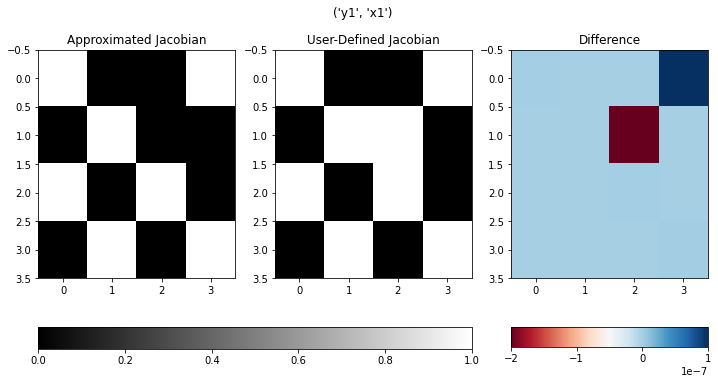

(<Figure size 864x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68cc0b5e10>,
       dtype=object))

In [3]:
import numpy as np
import openmdao.api as om

class ArrayComp2D(om.ExplicitComponent):
    """
    A fairly simple array component with an intentional error in compute_partials.
    """
    def setup(self):
        self.JJ = np.array([[1.0, 0.0, 0.0, 7.0],
                            [0.0, 2.5, 0.0, 0.0],
                            [-1.0, 0.0, 8.0, 0.0],
                            [0.0, 4.0, 0.0, 6.0]])
        # Params
        self.add_input('x1', np.zeros([4]))
        # Unknowns
        self.add_output('y1', np.zeros([4]))
        self.declare_partials(of='*', wrt='*')

    def compute(self, inputs, outputs):
        """
        Execution.
        """
        outputs['y1'] = self.JJ.dot(inputs['x1'])

    def compute_partials(self, inputs, partials):
        """
        Analytical derivatives.
        """
        # create some error to force the diff plot to show something
        error = np.zeros((4, 4))
        err = 1e-7
        error[0][3] = err
        error[1][2] = - 2.0 * err
        partials[('y1', 'x1')] = self.JJ + error

prob = om.Problem()
model = prob.model
model.add_subsystem('x_param1', om.IndepVarComp('x1', np.ones((4))), promotes=['x1'])
model.add_subsystem('mycomp', ArrayComp2D(), promotes=['x1', 'y1'])
prob.setup(check=False, mode='fwd')
check_partials_data = prob.check_partials(out_stream=None)

# plot with defaults
om.partial_deriv_plot('y1', 'x1', check_partials_data)
